In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import tree #модели деревьев решения
# %matplotlib inline
# plt.style.use('seaborn-v0_8')
import PyQt5
# %matplotlib qt

Работаем с данными о диабете

In [2]:
diabetes_data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/c21dd892cc0cc4fba3976b2a91559ff0/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/diabetes_cleaned.zip')
display(diabetes_data.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


Целевой признак - Outcome  
Наиб скоррелированные с ним - Glucose, BMI

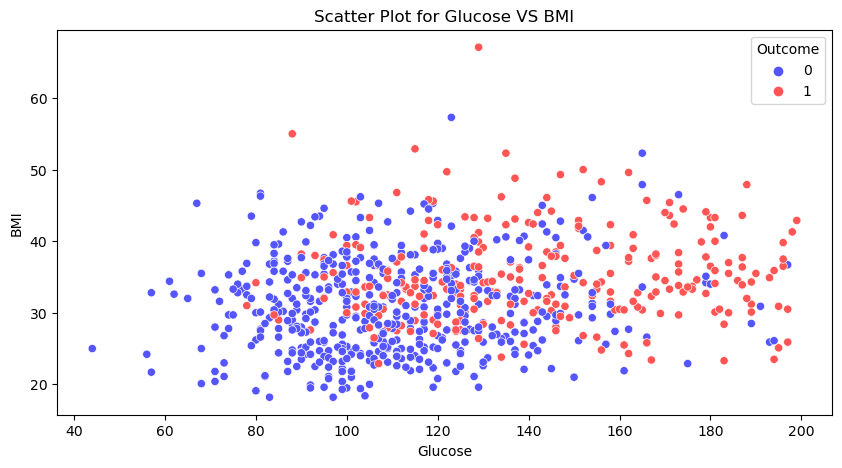

In [6]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('Scatter Plot for Glucose VS BMI');

In [6]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

#### Основные параметры DecisionTreeClassifier  
* `criterion` — критерий информативности ('`gini`' — критерий Джини и '`entropy`' — энтропия Шеннона).
* `max_depth` — максимальная глубина дерева (по умолчанию — None, глубина дерева не ограничена).
* `max_features` — максимальное число признаков, по которым ищется лучшее разбиение в дереве (по умолчанию — None, то есть обучение производится на всех признаках). Нужно потому, что при большом количестве признаков будет «дорого» искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков.
* `min_samples_leaf` — минимальное число объектов в листе (по умолчанию — 1). У этого параметра есть понятная интерпретация: если он равен 5, то дерево будет порождать только те решающие правила, которые верны как минимум для пяти объектов.
* `random_state` — число, отвечающее за генерацию случайных чисел.

Обучаем дерево решений с критерием информативности `criterion='entropy'` (энтропия Шеннона), максимальной глубиной `max_depth=3` и параметром `random_state=42`.

In [7]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_2d.fit(X.values, y.values)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

!!! если не поставить выше .values то ниже вылезет предупреждение.  
Изначально передавали в виде датафрейма, в итоге передаём в виде Numpy array  
https://stackoverflow.com/questions/69326639/sklearn-warning-valid-feature-names-in-version-1-0

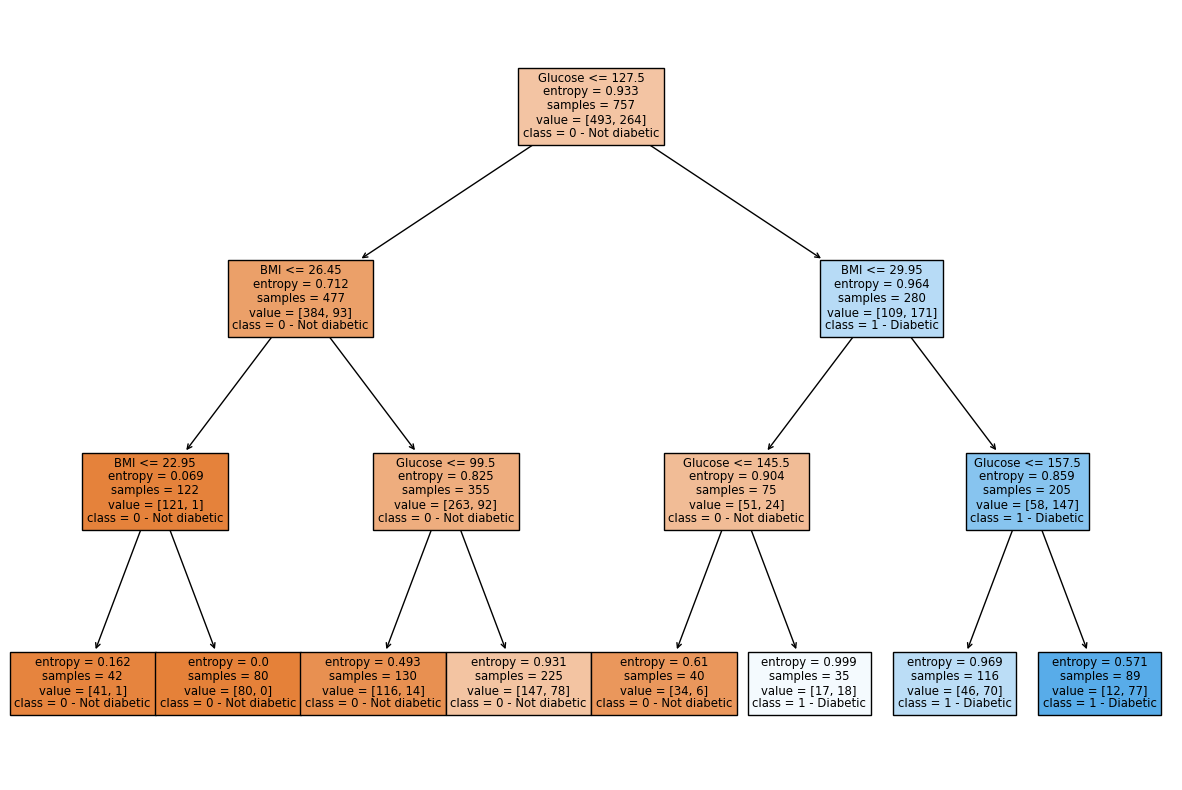

In [8]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf_2d, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

In [9]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = dt_clf_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


In [10]:
#Значения концентрации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = dt_clf_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 3)))

Predicted probabilities: [[0.135 0.865]]


Строим разделяющую поверхность дерева решений для двух признаков. Для этого воспользуемся функцией `plot_probabilities_2d()`.

In [11]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от 40 до 200, BMI — от 10 до 80
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(40, 200, 0.1),
        np.arange(10, 80, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(data=X, x='Glucose', y='BMI', hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

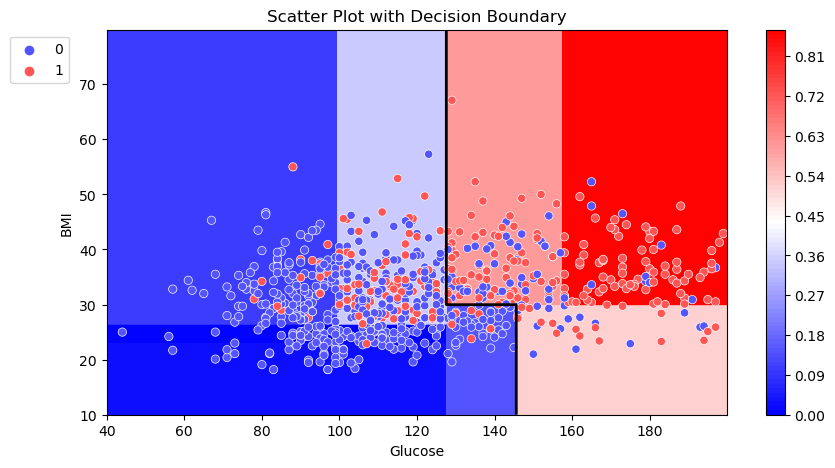

In [12]:
plot_probabilities_2d(X, y, dt_clf_2d)

In [13]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_2d.predict(X.values)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       493
           1       0.69      0.62      0.65       264

    accuracy                           0.77       757
   macro avg       0.75      0.74      0.74       757
weighted avg       0.77      0.77      0.77       757



Строим дерево без ограничения максимальной глубины

In [14]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART без ограничения его длины
dt_clf_bad.fit(X.values, y.values)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [15]:
#Делаем предсказание класса для всего набора данных
y_pred = dt_clf_bad.predict(X.values)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       493
           1       1.00      0.97      0.98       264

    accuracy                           0.99       757
   macro avg       0.99      0.98      0.99       757
weighted avg       0.99      0.99      0.99       757



In [16]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф 
tree_graph = tree.plot_tree(
    dt_clf_bad, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Not diabetic", "1 - Diabetic"], #имена классов
    filled=True, #расцветка графа
);

Глубина дерева

In [ ]:
dt_clf_bad.get_depth()

22

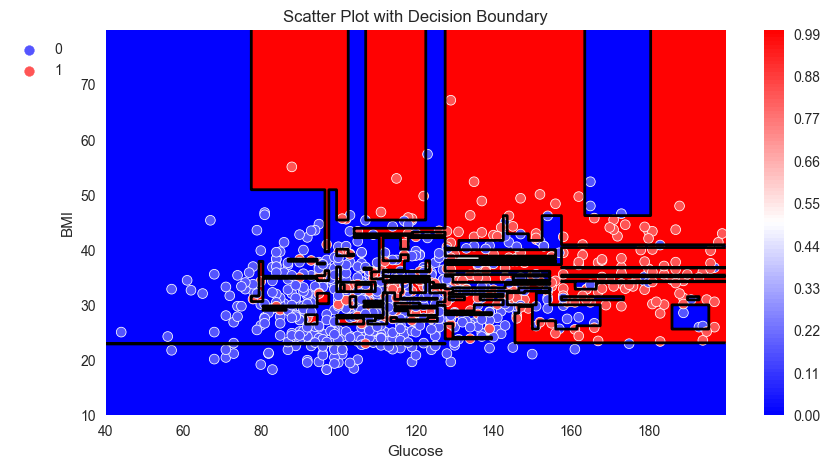

In [ ]:
# разделяющая поверхность
plot_probabilities_2d(X, y, dt_clf_bad)

Обучение дерева решений на всех признаках

In [ ]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

In [ ]:
#Создаём объект класса DecisionTreeClassifier
dt_clf_full = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
dt_clf_full.fit(X.values, y.values)
 
#Делаем предсказание класса
y_pred = dt_clf_full.predict(X.values)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       493
           1       0.84      0.69      0.76       264

    accuracy                           0.85       757
   macro avg       0.84      0.81      0.82       757
weighted avg       0.84      0.85      0.84       757



Важность признаков

In [ ]:
print(dt_clf_full.feature_importances_)

[0.02675774 0.36675873 0.03368236 0.04553664 0.24588118 0.14137465
 0.14000868]


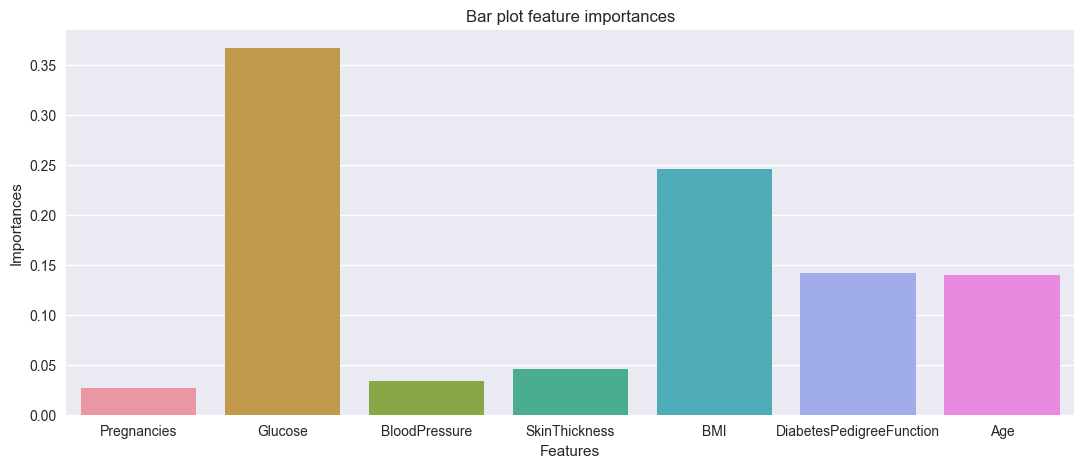

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = dt_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Примечание. Не стоит приравнивать значимость к корреляции. Корреляция — это коэффициент линейной зависимости, а значимость может отражать и нелинейные связи (в зависимости от сложности дерева).